In [1]:
# Import Sklearn libraries to build models 
from sklearn.feature_extraction.text import TfidfVectorizer # vectorize words 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
# Import Libraries to perform computation and do visualization. 
import pandas as pd
import numpy as np
np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
import string

# Import nltk to check english lexicon.
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk import word_tokenize, FreqDist
from nltk import pos_tag # for Parts of Speech tagging
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Generate wordcloud for word distribution visualization.
from wordcloud import WordCloud 

# Generating random numbers.
import random 

from xgboost import XGBClassifier

# Transforms text to a fixed-length vector of integers.
from gensim.models import Word2Vec 

import os

# !pip install -q textdistance
# import textdistance
#Efficient functions to search in strings.
import re as re 

# Import images for world cloud.
from PIL import Image, ImageDraw, ImageFont 


from tqdm.notebook import tqdm

from os import path
from os import environ

In [2]:
import tensorflow as tf

In [3]:
# !pip install tensorflow

In [5]:
# Uploading data 
DATASET_COLUMNS=["sentiment", "ids", "date", "flag", "user", "tweet"]
DATASET_ENCODING = "ISO-8859-1"
ta_df = pd.read_csv(r'D:\OneDrive - NITT\Custom_Download\training.1600000.processed.noemoticon.csv', 
                    encoding=DATASET_ENCODING, names=DATASET_COLUMNS,nrows=1000)

ta_df.head() #View Tweets Data Frame

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
ta_df['tweet'][0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [13]:
# Genarating a random sample of 1,000,000 tweets from a 1.6 million database 
ta_df = ta_df.sample(1000000,random_state=42)

In [14]:
# Checking shape
ta_df.shape

(1000000, 6)

In [15]:
# Dropping ‘flag’ and ‘ids’
ta_df.drop(['flag','ids'], axis=1, inplace = True)

In [16]:
# Checking tha the data is balanced 
ta_df['sentiment'].value_counts()

0    500167
4    499833
Name: sentiment, dtype: int64

In [17]:
# The variable target labeling in the data set is binary: 0 and 4, 
# where 0 represents the tweets that 
# are negative and 4 represents the tweets that are positive. 
ta_df['sentiment'] = ta_df['sentiment'].replace(4,1)
ta_df.head()

,sentiment,date,user,tweet
541200,0,Tue Jun 16 18:18:12 PDT 2009,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,Mon Apr 06 23:11:14 PDT 2009,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,Tue Jun 23 13:40:11 PDT 2009,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,Mon Jun 01 10:26:07 PDT 2009,Lamb_Leanne,School email won't open and I have geography ...
705995,0,Sat Jun 20 12:56:51 PDT 2009,yogicerdito,upper airways problem


In [18]:
tqdm.pandas() # Monitor completion 
ps = PorterStemmer() # defining and applying stemming to words in the text.

# text patterns that we want to remove from the text 
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# Replace 3 or more consecutive letters by 2 letter.
sequencePattern   = r"(.)\1\1+" 
seqReplacePattern = r"\1\1"
nltk.download('stopwords')
# Listst of common words we will removed from text.

stop_words = set(stopwords.words("english")) 

# The preprocess() function takes in the tweet and
# applies various text cleaning techniques to it.

def preprocess(text,apply_stem=True):
    
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(sequencePattern, seqReplacePattern, text)
    
    tokens = [] # Initializing an empty list to store tokenized words.
    for token in text.split():
        if token not in stop_words:  # Checking if the word is not a stopword
            
            if apply_stem:
               # Stemming to the word using the PorterStemmer if True
                tokens.append(ps.stem(token))  
            else:
                # Adding the original word if stemming is not applied.
                tokens.append(token) 
    # Joining and retuning the list of tokenized words into a single string
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
# Creating a new column in the DataFrame 
# Using lambda function aplying the 'preprocess()' 
# function to each row in the 'tweet' column.
ta_df['clean_tweet'] = ta_df['tweet'].progress_apply(lambda x:preprocess(x,True))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [20]:
# Creating a new column in the DataFrame without stemming  for wordcloud.
# Using lambda aplying the 'preprocess()' function to each row in the 'tweet' 
# column but adding 'false'.
ta_df['clean_tweet_wt_stem'] = ta_df['tweet'].progress_apply(lambda 
                                                        x:preprocess(x, False))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [21]:
# Splitting data target and clean tweets

X = ta_df['clean_tweet']#[:1000000]
y = ta_df['sentiment']#[:1000000]

In [22]:
# Spliting your dataset into training and testing sets. 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state = 43)

In [23]:
# Apllying tokenizing to the corpus using lambda
corpus = X.progress_apply(lambda line:line.split())

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [24]:
# View corpus
corpus

541200                                       [ahh, hope, ok]
750                              [cool, tweet, app, razr, 2]
766711     [know, famili, drama, lame, hey, next, time, u...
285055     [school, email, open, geographi, stuff, revis,...
705995                              [upper, airway, problem]
                                 ...                        
21340      [bad, time, lap, top, broken, good, time, foun...
80620                               [yeah, fun, think, movi]
411912     [ministri, agricultur, forest, keep, take, cat...
798815              [sad, news, farrah, fawcett, pass, away]
1406049    [indo, pro, shop, trocar, meu, celular, quando...
Name: clean_tweet, Length: 1000000, dtype: object

In [11]:
os.cpu_count()

8

In [25]:
# Train Word2Vec Model on corpus
WORD2VEC_MODEL = Word2Vec(corpus, 
                 min_count=1,          # word frequency
                 vector_size =300,      # dimention of word embeddings
                 workers=os.cpu_count(),            # Number of processors
                 sg=0 # default, 1 for skipgram and 0 for cbow
                ) 

In [26]:
# help(Word2Vec)

In [27]:
# Adding a new column and applying token to each row.
ta_df['tokens'] = (
    ta_df['clean_tweet']
    .progress_apply(lambda line: line.split())
)

  0%|          | 0/1000000 [00:00<?, ?it/s]

When the DataFrame is filtered using this True if len(line) else False,
 only the rows with at least one token in the 'tokens' column will be retained.

In [28]:
# Removing rows from ta_df if the 'tokens' column contains an empty list 
ta_df = ta_df[
    ta_df['tokens']
    .apply(lambda line: True if len(line) else False)
]

In [29]:
# all_word2vec_vocab = model.wv.vocab.keys()

In [31]:
# Max charecter size for a tweet
W2V_SIZE = 300 # its vector dimention

## Preparing to model the data

In [34]:
# Importing Keras libraries
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from keras_preprocessing.sequence import pad_sequences
# from keras.preprocessing.sequence import pad_sequences

In [35]:
# from keras_preprocessing.sequence import pad_sequences
# Downloading tensorflow library
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
%%time 
tokenizer = Tokenizer() # Initializing a new object 
tokenizer.fit_on_texts(X_train) # Tokenizer will learn the 
# vocabulary of the text data and assign a unique index to each word

# Vocabulary size (tokenizer reserves index 0)
vocab_size = len(tokenizer.word_index) + 1 
print("Total words", vocab_size)

Total words 162955
CPU times: user 8.64 s, sys: 55.1 ms, total: 8.7 s
Wall time: 8.67 s


In [13]:
np.zeros((162955,300)) = 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
# tokenizer.word_index

In [38]:
# KERAS
# Maximum length of the tweet. 
SEQUENCE_LENGTH = 300 

#Number of times it passes through the training data. 
EPOCHS = 10

# Number of training examples/samples to process at once during each iteration.
BATCH_SIZE = 1024

# https://medium.com/@dclengacher/keras-lstm-recurrent-
#neural-networks-c1f5febde03d

In [39]:
max(X_train.apply(lambda x: len(x))) # the maximum length of the text

174

Converting the tweets in training and testing to sequences of word indices using the tokenizer then padding them to have a fixed length of 300.



In [40]:
# Converting training and testing data to sequences of word 
# indices to prepare for the model.
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), 
                        maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), 
                       maxlen=SEQUENCE_LENGTH)

Word2Vec

Embedding matrix using a pre-trained Word2Vec model for words in the tweet learned by the tokenizer. The embedding matrix will be used to establish the weights of an embedding layer in a neural network.

In [41]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE)) # Initializing an empty
# embedding matrix with the shape
for word, i in tokenizer.word_index.items(): # Looping over each word in  tweet
  if word in WORD2VEC_MODEL.wv: # Checksing if the word is in Word2Vec model
    embedding_matrix[i] = WORD2VEC_MODEL.wv[word] # If yes, it assigns a vector
print(embedding_matrix.shape) # Printing shape

(162955, 300)


In [42]:
# embedding_matrix[95]

Creating an embedding layer using the Embedding class from Keras.

In [43]:
# Initializing embedding layers for our model 
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], 
                            input_length=SEQUENCE_LENGTH, trainable=False)

Layers to LSTM model

In [44]:
KERAS_MODEL = Sequential() # Creating a new sequential model
KERAS_MODEL.add(embedding_layer) # Adding embedding layer to the model.

# Dropout is a fraction of the neurons will drop in a layer during training. 
KERAS_MODEL.add(Dropout(0.5)) # Adding a dropout layer 
# Adding LSTM hidden layer with 100 neurons

KERAS_MODEL.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 


# Adding a dense output layer to the model with a one one output and 
# a sigmoid activation function ( this layerreceives input from all 
# the neurons in the previous layer.)

KERAS_MODEL.add(Dense(1, activation='sigmoid')) 

KERAS_MODEL.summary() # Print summary 

# https://heartbeat.comet.ml/using-a-keras-long-shortterm-memory-
# lstm-model-to-predict-stock-prices-a08c9f69aa74

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          48886500  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 49,047,001
Trainable params: 160,501
Non-trainable params: 48,886,500
_________________________________________________________________


Compilying the model, specifying the binary cross-entropy loss function, the Adam optimizer, and the accuracy metric.


In [45]:
# Compilying the model

KERAS_MODEL.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Learning the rate when the validation loss stops improving, and EarlyStopping stops training when the validation accuracy stops improving.

In [46]:
# Initializing callback
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [47]:
x_train.shape

(750000, 300)

In [48]:
y_train.shape

(750000,)

In [49]:
history = KERAS_MODEL.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1, 
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
660/660 [==============================] - 591s 884ms/step - loss: 0.5105 - accuracy: 0.7455 - val_loss: 0.4719 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 2/10
660/660 [==============================] - 572s 866ms/step - loss: 0.4881 - accuracy: 0.7614 - val_loss: 0.4689 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 3/10
660/660 [==============================] - 571s 865ms/step - loss: 0.4800 - accuracy: 0.7668 - val_loss: 0.4583 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 4/10
660/660 [==============================] - 569s 862ms/step - loss: 0.4746 - accuracy: 0.7701 - val_loss: 0.4535 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 5/10
660/660 [==============================] - 584s 885ms/step - loss: 0.4706 - accuracy: 0.7731 - val_loss: 0.4527 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 6/10
660/660 [==============================] - 574s 869ms/step - loss: 0.4686 - accuracy: 0.7742 - val_loss: 0.4535 - val_accuracy: 0.7850 - lr: 0.0010
Epoch 7/10
660/660 [==========================

### Saving the model


In [50]:
# Saving the model so that we don't need to keep training it.
KERAS_MODEL.save('keras_model.h5') # Saving LTSM
WORD2VEC_MODEL.save("model.w2v") # Saving Word2Vec

#### Loading the model

In [51]:
from tensorflow.keras.models import load_model # Import to load the model
# Loading  model
keras_model = load_model('keras_model.h5')

# summarize model.
# keras_model.summary()

### Results

In [52]:
# Showing Accuracy and Loss
score = keras_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

245/245 [==============================] - 26s 104ms/step - loss: 0.4517 - accuracy: 0.7864

ACCURACY: 0.7863839864730835
LOSS: 0.45171108841896057


 We are plotting the accuracy and loss values over the epochs of the model training, so we can get an idea of how the model is performing over time of the itteration in the neural network setting. 



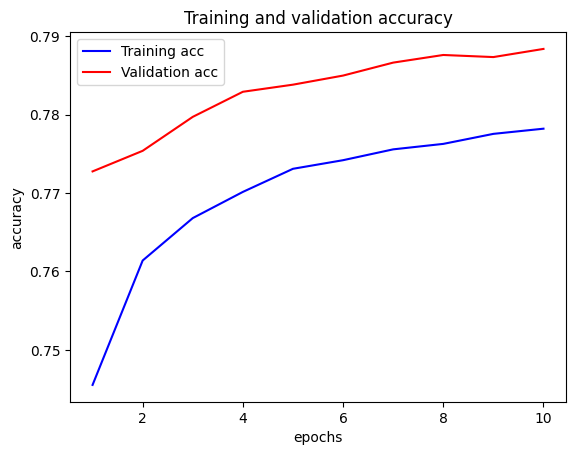

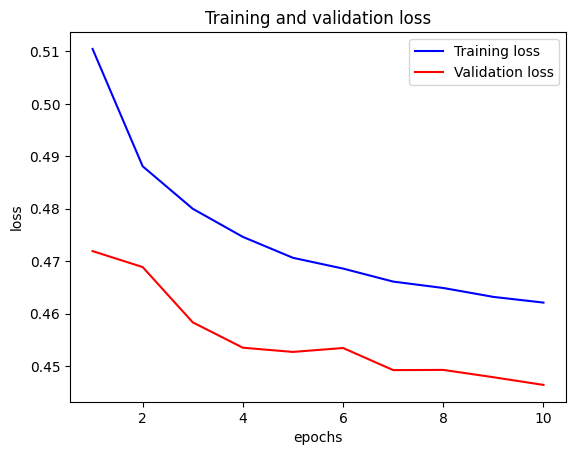

In [53]:
# Defining variables 

# Returning when calling the fit() method on a Keras LSTM model.
val_acc = history.history['val_accuracy']
acc = history.history['accuracy'] 
loss = history.history['loss']
val_loss = history.history['val_loss']
 
# it will give the epoch it stopped at after training or 
# 0 if it didn't early stop.
n = callbacks[1].stopped_epoch

# get X axis range
n = range(1,EPOCHS+1) if n==0 else range(1,n+2)

# epochs = range(EPOCHS) # range object 10

# Ploting training accuracy over the epochs in blue.
plt.plot(n, acc, 'b', label='Training acc')
plt.plot(n, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("epochs") # Labelng
plt.ylabel("accuracy") # Labelng
plt.legend()
 
plt.figure()

# Ploting training loss over the epochs in red.
plt.plot(n, loss, 'b', label='Training loss')
plt.plot(n, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epochs") # Labelng
plt.ylabel("loss") # Labeling
plt.legend()
 
plt.show()


# https://stackoverflow.com/questions/41908379/keras-plot-training-
#validation-and-test-set-accuracy

The training accuracy is increasing, and the validation accuracy is also increasing.
We are seeing the same patteren with the training loss graph. Loss is decreasing, and the validation loss as well. This suggests that the model is learning the patterns in the data and generalizing well to new data. In both graphs, when the epochs pass 6, the training and the vaidation are starting to get a little closer to one another. With higher than 10 epochs the model might be overfitting to the training data and not teaching the new data. 


In [54]:
y_test_1d = list(y_test)
scores = keras_model.predict(x_test, verbose=1, batch_size=1000)
y_pred_1d = [0 if score[0]<0.5 else 1 for score in scores ]

250/250 [==============================] - 25s 100ms/step


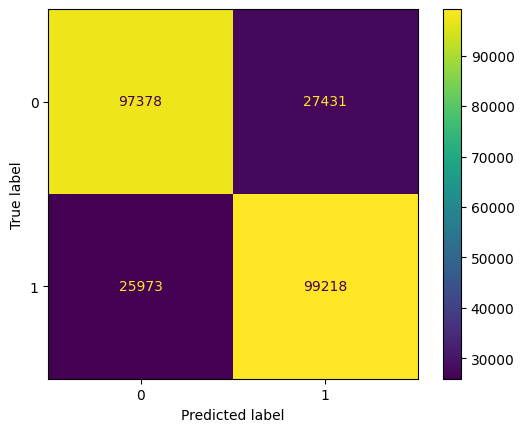

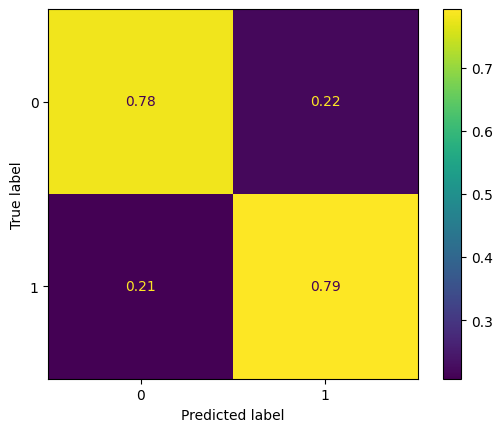

In [55]:
cm = confusion_matrix(y_test_1d,y_pred_1d)
cm1 = confusion_matrix(y_test_1d,y_pred_1d,normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=[0,1])
disp.plot()
disp1.plot()
plt.show()

In [56]:
print(classification_report(y_test_1d,y_pred_1d))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78    124809
           1       0.78      0.79      0.79    125191

    accuracy                           0.79    250000
   macro avg       0.79      0.79      0.79    250000
weighted avg       0.79      0.79      0.79    250000



In [14]:
import torch

In [15]:
import torch.nn as nn

In [17]:
x = nn.Embedding(10, 6)

In [21]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [22]:
rnn

LSTM(10, 20, num_layers=2)

In [23]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden

In [ ]:
1_ embedding
2) LSTM
3) linear


x = embedding(input)
x = lstm(x)
x(linear(x))

In [37]:
class mymodel:
    
    def __init__(self):
        print('const')
        
        
    def __call__(self):
        return 'i am in call'

In [38]:
model = mymodel()

const


In [39]:
model()

'i am in call'

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.

        D_in: input dimension
        H: dimension of hidden layer
        D_out: output dimension
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H) 
        self.linear2 = nn.Linear(H, D_out)

def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must 
        return a Variable of output data. We can use Modules defined in the 
        constructor as well as arbitrary operators on Variables.
        """
        
        x = self.linear1(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        
        
        h_relu = F.relu(self.linear1(x))
        y_pred = self.linear2(h_relu)
        return y_pred

In [42]:
#N is batch size; D_in is input dimension;
from torch.autograd import Variable
#H is the dimension of the hidden layer; D_out is output dimension.
N, D_in, H, D_out = 32, 100, 50, 10

#Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = Variable(torch.randn(N, D_in))  # dim: 32 x 100

#Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

#Forward pass: Compute predicted y by passing x to the model
y_pred = model(x) 

NotImplementedError: Module [TwoLayerNet] is missing the required "forward" function